Install datatsets

In [1]:
!pip install pytorch-nlp
!pip install spacy
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


It ensures that the model does not treat padding as the input. The mask indicates where pad value (defalut is 0) is present: it outputs a 1 at those locations, and a 0 otherwise.

## import all libararies

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np

# Mask


In [3]:
def create_padding_mask(src, pad=0):
  src_mask = (src == pad)
  # print(src_mask)
  # return src_mask[None, None, ...]
  return src_mask.unsqueeze(1).unsqueeze(1)

In [4]:
x = torch.tensor([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(x.shape)
print(create_padding_mask(x).shape)

torch.Size([3, 5])
torch.Size([3, 1, 1, 5])


The look-ahead mask is used to mask the future tokens in a sequence

In [5]:
def create_look_ahead_mask(size):
  mask = torch.triu(torch.ones(size, size), diagonal=1)
  device = torch.device("cuda")
  # mask_device = mask.to(device)
  # print(device)
  return (mask == 1).to(device)

In [6]:
def create_masks(src, tgt):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(src)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(src)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  dec_self_attention_look_ahead_mask = create_look_ahead_mask(tgt.shape[1])
  dec_self_attention_padding_mask = create_padding_mask(tgt)
  combined_mask = dec_self_attention_look_ahead_mask.logical_or(dec_self_attention_padding_mask)
  return enc_padding_mask, combined_mask, dec_padding_mask

# Positional encoding

In [7]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / torch.pow(10000, (2 * (i//2)) / d_model)
  return pos * angle_rates

In [8]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(torch.arange(position)[:, None],
                          torch.arange(d_model)[None, :],
                          d_model)
  # apply sin to even indices in the array position 2i
  angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array position 2i+1
  angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])
  device = torch.device("cuda")
  return (angle_rads[None, ...]).to(device) # 1 x 

torch.Size([1, 2048, 512])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 1.7590e-01, -9.8441e-01, -1.8606e-01,  ...,  9.7595e-01,
           2.1041e-01,  9.7761e-01],
         [-7.3331e-01, -6.7989e-01,  7.0155e-01,  ...,  9.7593e-01,
           2.1051e-01,  9.7759e-01],
         [-9.6832e-01,  2.4972e-01,  9.8535e-01,  ...,  9.7590e-01,
           2.1061e-01,  9.7757e-01]]], device='cuda:0')


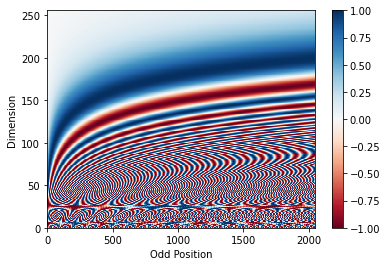

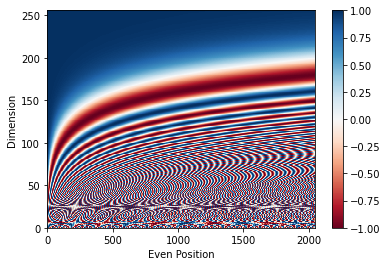

In [9]:
# we test the position dimension as 2048, model dimension 512
n_position, d_model = 2048, 512
pos_encoding = positional_encoding(n_position, d_model)
print(pos_encoding.shape)
print(pos_encoding)

# for draw position encoding
pos_encoding = pos_encoding[0].transpose(1, 0)
odd_pos_encoding = pos_encoding[0::2, :]
even_pos_encoding = pos_encoding[1::2, :]

plt.pcolormesh(odd_pos_encoding.cpu(), cmap='RdBu')
plt.ylabel('Dimension')
plt.xlabel('Odd Position')
plt.colorbar()
plt.show()
plt.pcolormesh(even_pos_encoding.cpu(), cmap='RdBu')
plt.ylabel('Dimension')
plt.xlabel('Even Position')
plt.colorbar()
plt.show()

# Scaled dot product attention

In [10]:
# calculation at s_q, d_k level
def scaled_dot_product_attention(query,keys,values, mask=None):
  # query = (batch size->d_b, head_num -> n_h, length of query ->s_q, head_szie =>d_q)
  # keys  = (batch size->d_b, head_num -> n_h, length of keys ->s_k, head_szie =>d_k)
  # values = (batch size->d_b, head_num -> n_h, length of values ->s_v, head_szie =>d_h)
  # d_q = d_h
  d_k = keys.shape[-1]
  dot_score = query@keys.transpose(-2,-1)  / math.sqrt(d_k) # compute dot product
  # check mask and drop-out
  if mask is not None:
    dot_score = dot_score.masked_fill(mask == 0, -1e9)
  attn_score = torch.softmax(dot_score, dim=-1)
  return attn_score@values, attn_score

In [11]:
key = torch.tensor([[10,0,0], [0,10,0], [0,0,10], [0,0,10]], dtype=torch.float64)
value = torch.tensor([[1,0], [10,0], [100,5], [1000,6]], dtype=torch.float64)
query = torch.tensor([[0, 0, 10], [0, 10, 0]], dtype=torch.float64)
_, attention_weights = scaled_dot_product_attention(query, key, value)
print("attention_weights:", attention_weights)                             

attention_weights: tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01],
        [8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]], dtype=torch.float64)


# **Multi-head Attention**

In [12]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.depth = d_model // num_heads
    self.d_model = self.num_heads * self.depth
    # init layers
    self.wq = nn.Linear(d_model, d_model)
    self.wk = nn.Linear(d_model, d_model)
    self.wv = nn.Linear(d_model, d_model)
    self.wo = nn.Linear(d_model, d_model)
  
  def reshape_for_multi_heads_attention(self, t):
    # change the size to attention computation required size
    # d_model => num_heads x depth
    batch_size = t.shape[0]
    t = t.view(batch_size, -1, self.num_heads, self.depth) # (batch_size, seq_len, num_heads, depth)
    return t.transpose(1, 2) # (batch_size, num_heads, seq_len, depth)

  def forward(self, q, k, v, mask):
    batch_size = q.shape[0]
    # apply linear transformations
    q = self.wq(q) # (batch_size, seq_len, d_model)
    k = self.wk(k)
    v = self.wv(v)
    # change the size to attention computation required size
    # d_model => num_heads x depth 
    q = self.reshape_for_multi_heads_attention(q)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.reshape_for_multi_heads_attention(k)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.reshape_for_multi_heads_attention(v)  # (batch_size, num_heads, seq_len_v, depth)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) # (batch_size, num_heads, seq_len_q, depth)
    # concate q, k v from different heads
    scaled_attention = scaled_attention.transpose(2, 1).contiguous().view(batch_size, -1, self.d_model) # (batch_size, seq_len_q, d_model)
    return self.wo(scaled_attention)

# Encoder

In [13]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
  
  def forward(self, x):
    return self.w_2(F.relu(self.w_1(x)))

In [14]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
      super(EncoderLayer, self).__init__()
      self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
      self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
      self.layernorm1 = nn.LayerNorm(d_model)
      self.layernorm2 = nn.LayerNorm(d_model)
      self.dropout1 = nn.Dropout(dropout)
      self.dropout2 = nn.Dropout(dropout)

  def forward(self, x, mask):
    attention_output = self.dropout1(self.multi_head_attention(x, x, x, mask))
    ffn_input = self.layernorm1(x + attention_output)
    ffn_output = self.dropout2(self.feed_forward(ffn_input))
    output = self.layernorm2(ffn_input + ffn_output)
    return output


In [15]:
class Encoder(nn.Module):
  def __init__(self, n_layer, d_model, num_heads, d_ff, dropout=0.1):
    super(Encoder, self).__init__()
    self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(n_layer)]
  
  def forward(self, x, mask):
    for layer in self.enc_layers:
      x = layer(x, mask)
      print("x", x)
    return x

# Decoder

In [16]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
      super(DecoderLayer, self).__init__()
      self.self_attention = MultiHeadAttention(d_model, num_heads)
      self.cross_attention  = MultiHeadAttention(d_model, num_heads)
      self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
      self.layernorm1 = nn.LayerNorm(d_model)
      self.layernorm2 = nn.LayerNorm(d_model)
      self.layernorm3 = nn.LayerNorm(d_model)
      self.dropout1 = nn.Dropout(dropout)
      self.dropout2 = nn.Dropout(dropout)
      self.dropout3 = nn.Dropout(dropout)

  def forward(self, x, enc_output, padding_mask, look_ahead_mask):
    self_attention_output = self.dropout1(self.self_attention(x, x, x, look_ahead_mask))
    cross_attention_input = self.layernorm1(x + self_attention_output)

    cross_attention_output = self.dropout2(self.cross_attention(x, enc_output, enc_output, padding_mask))
    ffn_input = self.layernorm2(cross_attention_output + cross_attention_output)

    ffn_output = self.dropout3(self.feed_forward(ffn_input))
    output = self.layernorm3(ffn_input + ffn_output)
    return output

In [17]:
class Decorder(nn.Module):
  def __init__(self, n_layer, d_model, num_heads, d_ff, dropout=0.1):
    super(Decorder, self).__init__()
    self.dec_layers = [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(n_layer)]
  
  def forward(self, x, enc_output, padding_mask, look_ahead_mask):
    for layer in self.dec_layers:
      x = layer(x, enc_output, padding_mask, look_ahead_mask)
    return x

# Transformer

In [18]:
class Transformer(nn.Module):
  def __init__(self, n_encoder_layer, n_decorder_layer, src_vocab_size, tgt_vocab_size, max_sen_len, d_model, num_heads, d_ff, dropout):
    super(Transformer, self).__init__()
    self.src_embedding = nn.Embedding(src_vocab_size, d_model)
    self.pos_encoding = positional_encoding(max_sen_len, d_model)
    self.encoder = EncoderLayer(d_model, num_heads, d_ff, dropout)
    # decoder
    self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
    self.decoder = DecoderLayer(d_model, num_heads, d_ff, dropout)
    self.linear = nn.Linear(d_model, tgt_vocab_size)

  def forward(self, x, y, src_padding_mask, tgt_padding_mask, tgt_look_ahead_mask):
    src_sen_len = x.shape[1]
    tgt_sen_len = y.shape[1]
    # print(self.src_embedding(x).shape)
    # print(self.pos_encoding.shape)
    # print(self.pos_encoding[:, :src_sen_len, :].shape)
    # print(x.is_cuda)
    # print(y.is_cuda)
    # print(src_padding_mask.is_cuda)
    # print(tgt_padding_mask.is_cuda)
    # print(tgt_look_ahead_mask.is_cuda)
    enc_output = self.encoder(self.src_embedding(x) + self.pos_encoding[:, :src_sen_len, :], src_padding_mask)
    # print(self.tgt_embedding(y).shape)
    # print(self.pos_encoding[:, :tgt_sen_len, :].shape)
    dec_output = self.decoder(self.tgt_embedding(y) + self.pos_encoding[:, :tgt_sen_len, :], enc_output, tgt_padding_mask, tgt_look_ahead_mask)
    output = F.log_softmax(self.linear(dec_output), dim=-1) # apply linear first
    return output

# Loss function

In [19]:
class Loss(nn.Module):
  def __init__(self):
    super(Loss, self).__init__()
    self.criterion = nn.NLLLoss()

  def forward(self, pred, tgt):
    return criterion(torch.log(pred), tgt)

# Optimizer

In [20]:
class Dynamic_LR_Scheduler():
    def __init__(self, d_model, beta1, beta2, epsilon, warmup_step, optimizer, factor = 1):
        super(Dynamic_LR_Scheduler, self).__init__()
        self.d_model= d_model
        self.beta1= beta1
        self.beta2= beta2
        self.epsilon = epsilon
        self.warmup_step = warmup_step
        self.optimizer = optimizer
        self.step_num = 0
        self.lr = 0
        self.factor = factor
        
    def step(self):
        self.step_num += 1
        lr = self.learning_rate()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.lr = lr
        return self.optimizer.step()
        
    def learning_rate(self):
        return self.factor * \
            (self.d_model ** (-0.5) *
            min(self.step_num ** (-0.5), self.step_num * self.warmup_step ** (-1.5)))

# Label Smoothing

In [21]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="batchmean")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        # print(true_dist)
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)

In [22]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(predict.log(), torch.LongTensor([2, 1, 0]))

In [23]:
v

tensor(inf)

In [24]:
v

tensor(inf)

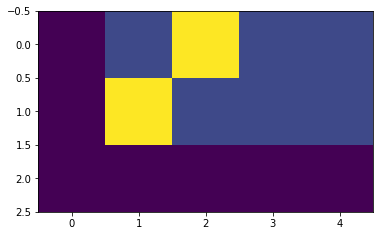

In [25]:
plt.imshow(crit.true_dist)

# Loading Training Data

In [26]:
from torchnlp.datasets import iwslt_dataset

train_text = iwslt_dataset(directory="data/", train=True, check_files=[], url="http://cs.cornell.edu/~junxiong/data.tgz")
validation_text = iwslt_dataset(directory="data/", dev=True, check_files=[], url="http://cs.cornell.edu/~junxiong/data.tgz")
test_text = iwslt_dataset(directory="data/", test=True, check_files=[], url="http://cs.cornell.edu/~junxiong/data.tgz")

data.tgz: 23.6MB [00:02, 9.09MB/s]                           
data.tgz: 23.6MB [00:02, 10.6MB/s]                           
data.tgz: 23.6MB [00:02, 9.41MB/s]                           


In [27]:
print(train_text[:3])

[{'en': "David Gallo: This is Bill Lange. I'm Dave Gallo.", 'de': 'David Gallo: Das ist Bill Lange. Ich bin Dave Gallo.'}, {'en': "And we're going to tell you some stories from the sea here in video.", 'de': 'Wir werden Ihnen einige Geschichten über das Meer in Videoform erzählen.'}, {'en': "We've got some of the most incredible video of Titanic that's ever been seen, and we're not going to show you any of it.", 'de': 'Wir haben ein paar der unglaublichsten Aufnahmen der Titanic, die man je gesehen hat,, und wir werden Ihnen nichts davon zeigen.'}]


In [28]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torchtext

de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(text, tokenizer):
  counter = Counter()
  for string_ in text:
    counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=2)

de_vocab = build_vocab(list(map(lambda x: x['de'], train_text)), de_tokenizer)
en_vocab = build_vocab(list(map(lambda x: x['en'], train_text)), en_tokenizer)

In [29]:
print(len(en_vocab))
print(len(de_vocab))

36622
59342


In [30]:
def data_process(text):
  data = []
  for sen in text:
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(sen['en'])],
                            dtype=torch.long)
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(sen['de'])],
                            dtype=torch.long)
    data.append((en_tensor_, de_tensor_))
  return data

train_data = data_process(train_text)
val_data = data_process(validation_text)
test_data = data_process(test_text)

In [31]:
# print(test_data[3])
# print(val_data[3])
# print(train_data[3])
# print(len(de_vocab))
# print(len(en_vocab))
for (i, j) in train_data:
  if torch.max(i) >= 36622:
    print(i)

In [32]:
# batchify data
# BATCH_SIZE = 25000
BATCH_SIZE = 5

EN_PAD_IDX = en_vocab['<pad>']
EN_BOS_IDX = en_vocab['<bos>']
EN_EOS_IDX = en_vocab['<eos>']
DE_PAD_IDX = de_vocab['<pad>']
DE_BOS_IDX = de_vocab['<bos>']
DE_EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([DE_BOS_IDX]), de_item, torch.tensor([DE_EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([EN_BOS_IDX]), en_item, torch.tensor([EN_EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=DE_PAD_IDX).transpose(0, 1)
  en_batch = pad_sequence(en_batch, padding_value=EN_PAD_IDX).transpose(0, 1)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [33]:
src_max_sen_len = max(max(i.shape[0], j.shape[0]) for (i, j) in train_data)
print(src_max_sen_len)
print(max(i.shape[0] for (i, j) in train_data))
print(max(j.shape[0] for (i, j) in train_data))

print(en_vocab['<unk>'])
print(en_vocab['<pad>'])
print(en_vocab['<bos>'])
print(en_vocab['<eos>'])

print(de_vocab['<unk>'])
print(de_vocab['<pad>'])
print(de_vocab['<bos>'])
print(de_vocab['<eos>'])

763
753
763
0
1
2
3
0
1
2
3


# Training

In [ ]:
import time
from tqdm import tqdm

device = torch.device('cuda')


def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          scheduler: Dynamic_LR_Scheduler,
          criterion: nn.Module):
    # train model
    model.train()
    epoch_loss = 0
    for _, (src, tgt) in tqdm(enumerate(iterator)):
        # print(device)
        src, tgt = src.to(device), tgt.to(device)
        tgt_inp = tgt[:, :-1]
        tgt_real = tgt[:, 1:]
        scheduler.optimizer.zero_grad()
        # generate mask for model
        src_padding_mask, tgt_look_ahead_mask, tgt_padding_mask = create_masks(src, tgt_inp)
        # print(src_padding_mask.shape)
        # print(tgt_look_ahead_mask.shape)
        # print(tgt_padding_mask.shape)
        output = model(src, tgt_inp, src_padding_mask, tgt_padding_mask, tgt_look_ahead_mask) # batch size x sentence size x vab size
        # whether to remove the first word and last
        output = output.view(-1, output.shape[-1])
        tgt_real = tgt_real.contiguous().view(-1)
        loss = criterion(output, tgt_real)
        loss.backward()
        scheduler.step()
        epoch_loss += loss.item()
        # print("bloss:", loss.item())
        # torch.cuda.empty_cache()
    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for _, (src, tgt) in enumerate(iterator):
            src, tgt = src.to(device), tgt.to(device)
            tgt_inp = tgt[:, :-1]
            tgt_real = tgt[:, 1:]
            src_padding_mask, tgt_look_ahead_mask, tgt_padding_mask = create_masks(src, tgt_inp)
            output = model(src, tgt_inp, src_padding_mask, tgt_padding_mask, tgt_look_ahead_mask)
            # change shape
            output = output.view(-1, output.shape[-1])
            tgt_real = tgt_real.contiguous().view(-1)
            loss = criterion(output, tgt_real)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 10
# configuration
n_encoder_layer = 6
n_decorder_layer = 6
src_vocab_size = len(en_vocab)
tgt_vocab_size = len(de_vocab)
max_sen_len = max(max(i.shape[0], j.shape[0]) for (i, j) in train_data)+2 # for the special token
d_model = 512
num_heads = 8
d_ff = 2048
dropout = 0.1

beta1 = 0.9
beta2 = 0.98
epsilon = 10**(-9)
warmup_step = 4000

model = (Transformer(n_encoder_layer, n_decorder_layer, src_vocab_size, tgt_vocab_size, max_sen_len, d_model, num_heads, d_ff, dropout)).cuda()
PAD_IDX = en_vocab.stoi['<pad>']
# criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
criterion = LabelSmoothing(tgt_vocab_size, padding_idx=0, smoothing=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = Dynamic_LR_Scheduler(d_model, beta1, beta2, epsilon, warmup_step, optimizer)


for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iter, scheduler, criterion)
    valid_loss = evaluate(model, valid_iter, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_iter, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

39377it [13:43, 47.81it/s]
5it [00:00, 42.55it/s]

Epoch: 01 | Time: 13m 44s
	Train Loss: 3.725 | Train PPL:  41.475
	 Val. Loss: 3.545 |  Val. PPL:  34.634


39377it [13:42, 47.86it/s]
5it [00:00, 41.38it/s]

Epoch: 02 | Time: 13m 43s
	Train Loss: 3.652 | Train PPL:  38.547
	 Val. Loss: 3.595 |  Val. PPL:  36.424


39377it [13:45, 47.69it/s]
5it [00:00, 42.62it/s]

Epoch: 03 | Time: 13m 46s
	Train Loss: 3.630 | Train PPL:  37.712
	 Val. Loss: 3.486 |  Val. PPL:  32.668


30824it [10:44, 48.53it/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)